# Introduction to `tidyverse`
An ["opinionated" collection of R packages](https://tidyverse.org) for data science, driven by a coherent underlying design philosophy.
These packages are meant to help you with two essential processes:
1. **Data clean-up and organization**: Structure should be intuitive, so that it's easy to model, manipulate, and think about the data
2. **Data plotting**: The grammar of graphics (Week 13)

In [ ]:
# Loading the packages
# install.packages("tidyverse")
library(tidyverse)

## Datasets
Tables with named columns. We already encountered them when we discussed counterbalancing and `expyriment` data outputs.
| subject_id   | trial_number    | trial_type | rt       |
| ----- | ---- | ---- | ---- |
| 1 | 1 | congruent | 520 |
| 1 | 2 | incongruent | 720 |

### Tidy datasets
**Each variable is one column, each observation is one row**

Here's an example of a dataset that is **not** tidy:
| subject_id   | rt_trial_1    | rt_trial_2 | rt_trial_3  |
| ----- | ---- | ---- | ---- |
| 1 | 520 | 700 | 673 |
| 1 | 484 | 635 | 912 |

If you don't mess up too much with `expyriment`, it will already output the data in the right format for you!

## Essential `tidyverse`
The basic unit of analysis in tidyverse is the tibble, which is a convenient data structure for datasets

In [ ]:
var1 <- c(1, 2, 3)
var2 <- 2 * var1
tibble(var1, var2) # Create a tibble from the two vectors (column names are automatically stored from the vector variable names)

Usually, though, we already have the data to be analyzed waiting for us on the computer

### Loading the data

This is the data of one subject participating in a size Stroop experiment.

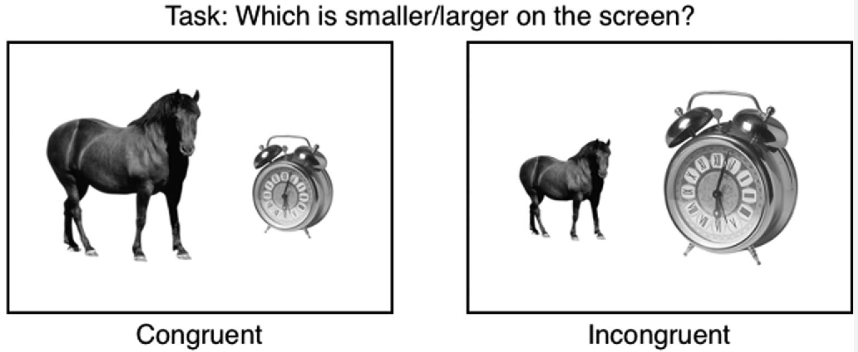

**Experiment information**
On each trial, participants were shown two images and they had to select the smaller one ('f' = select the image on the left; 'j' = select the image on the right). On congruent trials, the real-world size relation matched the on-screen relation (e.g., small pigeon versus large camel). On incongruent trials, it did not (e.g., large pigeon versus small camel).

- Object pairs (pigeon-camel, croissant–bread, etc.): 60
- Trial type: Congruent vs incongruent
- Side of correct response: Left vs right
- Number of trials: 60 object pairs $\times$ 2 sides $\times$ 2 trial types = 240
- Inter-trial interval: 700
- Feedback: Only if incorrect for 5,000 ms

Let's load it.

In [ ]:
full_data <- read_csv("data/148338_220209_095045_M057814.csv")

We got some warning messages, but let's ignore them for the moment and inspect the data.

In [ ]:
print(data)

If you want to see how the first/last part of the data looks like, use `head(data, n)`/`tail(data, n)`:

In [ ]:
head(data, n=6)
tail(data, n=10)

Because of the first two rows, which collect demographic and browser information, `read_csv` doesn't know how to read the actual behavioral data that starts on row 3. We can easily fix this by telling tidyverse how many rows to skip:

In [ ]:
data <- read_csv("data/148338_220209_095045_M057814.csv", skip=2)
print(data)

You can see that `tidyverse` already imposes some structure on the data. For instance, it tries to guess the type of variable that is stored in each column: `dbl` = numeric, `chr` = string. You can always convert variables from one type to another later.

### Inspecting the dataset

In [ ]:
str(data) # Data structure

In [ ]:
glimpse(data) # A transposed version of print: columns are rows

In [ ]:
summary(data) # An attempt to summarize the information contained in the data

### Data tidying

The first thing to notice is that row 1 of the tibble looks different from the rest. This is because on the first "trial", the participant was asked about their education level. We want to get rid of that row without losing that information. But, first, where is that information stored to begin with?

#### Rows

In [ ]:
head(data, 3)

It's in the `response` column in row 1. Let's extract this value and put it inside a new column called `education`.  
We can initialize new columns with `mutate`.

In [ ]:
mutate(data, education = first(response)) # Create a new column called 'education' and place the first value in the 'response' column there

Now that we have stored the education level of the participant, we can get rid of the first row, so that we're only left with the data from the test trials. We can easily filter the dataset by using the aptly called `filter` function.

In [ ]:
filter(mutate(data, education = first(response)), trialType != "form")

**Two important observations**:
1. This looks incredibly unwieldy already, and we have only applied two operations to the tibble:
```R
filter(mutate(data, education = first(response)), trialType != "form")
```
Fortunately, `tidyverse` has a special operator ("pipe"), `%>%`, which allows you to chain multiple function applications while keeping the code readable. Instead of writing `f(g(x))`, we write `x %>% f() %>% g()`. This simply means that whatever is to left of the pipe will be **passed as the first argument** to the function on the right.

In [ ]:
data %>%
    mutate(education = first(response)) %>%
    filter(trialType != "form")

2. Our commands above will not change the `data` object in-place. For that, we need to explicitly reassign the modified tibble to the variable called `data`.

In [ ]:
data <- data %>%
    mutate(education = first(response)) %>%
    filter(trialType != "form")

Let's also store the participant's ID and age, which we can find on the first row of `full_data`

In [ ]:
ID <- full_data %>% pull(id) %>% first()
age <- full_data %>% pull(age) %>% first()

data <- data %>% mutate(ID = ID, age = age)

#### Columns

We now have all the rows that we want—those corresponding to the 240 trials. What about the columns? Let's inspect the data again:

In [ ]:
summary(data)

Some columns are clearly irrelevant. For instance, you can see in the output of `summary(data)` that `ITI` and `feedbackTime` have the same value in all rows. You can also see that `if`, `then`, `fixation`, and `button1` are empty. This is because these variables only mattered for the demographic data-collection trial.

We can get rid of columns via `select`, where you can specify either which column you want to keep, `select(data, cols = c("col1", "col2"))`, or which column you want to remove, `select(data, cols = -c("col3", "col4"))`.

In [ ]:
data %>% select(-c(ITI, feedbackTime, `if`:button1)) # Remove ITI, feedbackTime, and all the columns between if and button1 (inclusive).
# The ticks around `if` are necessary because if is a keyword in R (whoever chose this as a column name was not thinking clearly)

From inspecting the table, it's also clear that `stimFormat` equals ".jpg" everywhere, that many columns have NA-values everywhere (e.g. `head`, `responseType`) so let's get rid of them as well. We can get rid of them in one fell swoop by combining `select` and `where`.

In [ ]:
data %>% 
    select(where(function(col) { n_distinct(col) > 1 })) # Select all the columns where the number of distinct classes is higher than 1

Already looks much more manageable. But there are still issues. First, we lost the `education` column. Second, the `stimPos` and `stimPos_actual` column encode the same information, so one of them can be eliminated. Second, `ITI_ms`, and `ITI_f`, and `ITI_fDuration` are estimations of timing parameters, that we can ignore in the analysis. Third, `row_no` is shuffled during counterbalancing, so we might want to replace that with the `trial_number` which is actually missing.

In [ ]:
data %>% 
    select(where(~ n_distinct(.x) > 1 ), education:age) %>% # Some syntactic sugar (anonymous function) + Keep education level
    select(-c(stimPos_actual, ITI_ms, ITI_f, ITI_fDuration, rowNo)) %>%
    mutate(trial_number = row_number())

We will now arrange the columns in a more systematic order: Subject info, trial info, response info.

In [ ]:
(tidy_data <- data %>% 
    select(where(~ n_distinct(.x) > 1), education:age) %>% # Some syntactic sugar (anonimous function) + Keep education level
    select(-c(stimPos_actual, ITI_ms, ITI_f, ITI_fDuration, rowNo)) %>%
    mutate(trial_number = row_number()) %>%
    select(ID, age, education, trial_number, timestamp, trialType, stim1, stim2, stimPos:correct))

There are still issues:
1. Column names are not transparent: `rename(new_name = old_name)` allows us to fix this.
2. Column name styles are not consistent: `trial_number` vs `trialType`.

In [ ]:
data %>% 
    select(where(~ n_distinct(.x) > 1), education:age) %>% # Some syntactic sugar (anonimous function) + Keep education level
    select(-c(stimPos_actual, ITI_ms, ITI_f, ITI_fDuration, rowNo)) %>%
    mutate(trial_number = row_number()) %>%
    select(ID, age, education, trial_number, timestamp, trialType, stim1, stim2, stimPos:correct) %>%
    rename(
        id = ID, trial_type = trialType, 
        stim_pos = stimPos, stim_left = stim1, stim_right = stim2, 
        correct_key = key, correct_side = correctSide,
        rt = RT
    )

In [ ]:
data %>% 
    select(where(~ n_distinct(.x) > 1), education:age) %>% # Some syntactic sugar (anonimous function) + Keep education level
    select(-c(stimPos_actual, ITI_ms, ITI_f, ITI_fDuration, rowNo)) %>%
    mutate(trial_number = row_number()) %>%
    select(ID, age, education, trial_number, timestamp, trialType, stim1, stim2, stimPos:correct) %>%
    rename(
        id = ID, trial_type = trialType, 
        stim_pos = stimPos, stim_left = stim1, stim_right = stim2, 
        correct_key = key, correct_side = correctSide,
        rt = RT
    ) %>% head()

Instead of removing columns, one can also create a new tibble by using `transmute`, which provides a handy combination of `select` and `mutate`.

In [ ]:
tidy_data <- data %>% 
    transmute(
        id = ID, age, education, 
        trial_number = row_number(),
        timestamp, 
        trial_type = trialType,
        stim_left = stim1,
        stim_right = stim2,
        stim_pos = stimPos,
        response,
        rt = RT
    )

tidy_data %>% head()

You may have noticed that I've left several columns out when creating the `tidy_data` object. This is just to introduce the option of creating new columns and populating it with values that depend on values in other columns (row-wise). For instance, if I know which of the image is small (`stim_left` vs `stim_right`), I can compute on which side the smaller image, from which I can compute the correct key for that particular trial, from which I can compute whether the participant was correct.

In [ ]:
# Option 1: if-else
tidy_data %>%
    # For every row, is the string "Small" contained in the `stim_left` column? If yes, the small image (and correct side) is on the left. If not, it's on the right.
    mutate(correct_side = ifelse(test = str_detect(stim_left, "Small"), yes = "left", no = "right")) %>%
    head()

# Option 2: case-when (for more than 2 cases)
tidy_data %>%
    mutate(correct_side = case_when(
        str_detect(stim_left, "Small") ~ "left",
        str_detect(stim_left, "Large") ~ "right",
        )) %>%
    head()

#### Exercise 1 
To the `tidy_data` object above, add `correct_side`, `correct_key`, `correct_response`, and `error`, using the conditional `mutate` where necessary.

In [ ]:
# tidy_data <- tidy_data %>% ...

In [ ]:
summary(tidy_data)

Our data is not perfectly tidy but it will do for now. (What else could we do to improve it?)

### Summarizing the data

Let's find out how easy the task was for our participant and how much time s/he needed to reach a decision: `summarize` provides a quick way to obtain various kinds of information.

In [ ]:
tidy_data %>% 
    summarize(accuracy = mean(correct_response), rt = mean(rt))

#### Exercise 2
It may be useful (e.g., for excluding participants) to add sumamry statistics to the dataset itself in new column. Add the average accuracy and response time to `tidy_data` as `mean_accuracy` and `mean_rt`.

What about the effect of trial type? For that, we need to group our dataset depending on the condition(s) we are interested in analyzing using `group_by`.

In [ ]:
tidy_data %>%
    group_by(trial_type) %>%
    summarize(accuracy = mean(correct_response), rt = mean(rt))

#### Exercise 3
Find out if there is a SNARC-like effect: Are participants faster when the small image is on the left? 

#### Exercise 4
Does the SNARC-like effect depend on trial type?

### A full dataset
We load all the 12 csv files in the 'data' folder, then apply the `read_csv` function to each of them using `map_dfr`. The `.id` argument creates a column that keeps the information from each file separate. This is equivalent to having a subject_id, if there is one .csv file per participant.

In [ ]:
raw_data <- list.files(path = 'data', pattern = ".csv$", full.names = TRUE) %>% #
  map_dfr(read_csv, col_types = cols(), skip = 2, .id = 'id')

#### Exercise 5
Tidy the dataset.
Keep the education-level information for each subject (Hint: group the tibble before calling `first(response)`), then follow the same steps as before to obtain a tidy dataset. Use `ungroup()` to return to the tibble to the ungrouped state:
```R
tibble %>% 
    group_by(X, Y, Z)
    mutate(new_column = ...) # value computed by X, Y, Z
    ungroup()
```

#### Exercise 6
Trials where the responses were too slow or too fast should be excluded from the analysis. (Why would that be?)
Exclude the trials where the response is below 200 ms or higher than 1,500 ms.

Print out the total number and the proportion of excluded trials (Hint: Use `nrow(tibble)`).

In [ ]:
# filtered_trials <- ...

#### Exercise 7
Exclude participants who didn't achieve 93% overall accuracy. Print out the total number and the proportion of excluded subjects (Hint: Use `pull(tibble, column)` to extract the `id` column into a vector, then use `n_distinct` to obtain the number of unique values).

In [ ]:
# filtered_id <- ...

#### Exercise 8
Summarize the response-time and accuracy measures by trial type to check whether there's a Stroop effect.

### Reformatting the data: `pivot_wider`, `pivot_longer`

What if we want to compute the Stroop effect (incongruent - congruent reaction times) for each participant? We cannot obtain the difference directly, since the incongruent and congruent values are stored on different rows:

In [ ]:
filtered_id %>% 
    group_by(id, trial_type) %>%
    summarize(rt = mean(rt)) %>%
    ungroup()

The solution is to reformat the table from the long format is currently in (22 $\times$ 4) to a wide format, in which trial type moves from being distributed over rows to being distributed across columns. 

Tidyverse has two functions, `pivot_wider` and `pivot_longer`, which allow us to achieve just that. (For me, these were the hardest functions to master when learning this.) Let's start with `pivot_wider`.

#### `pivot_wider`
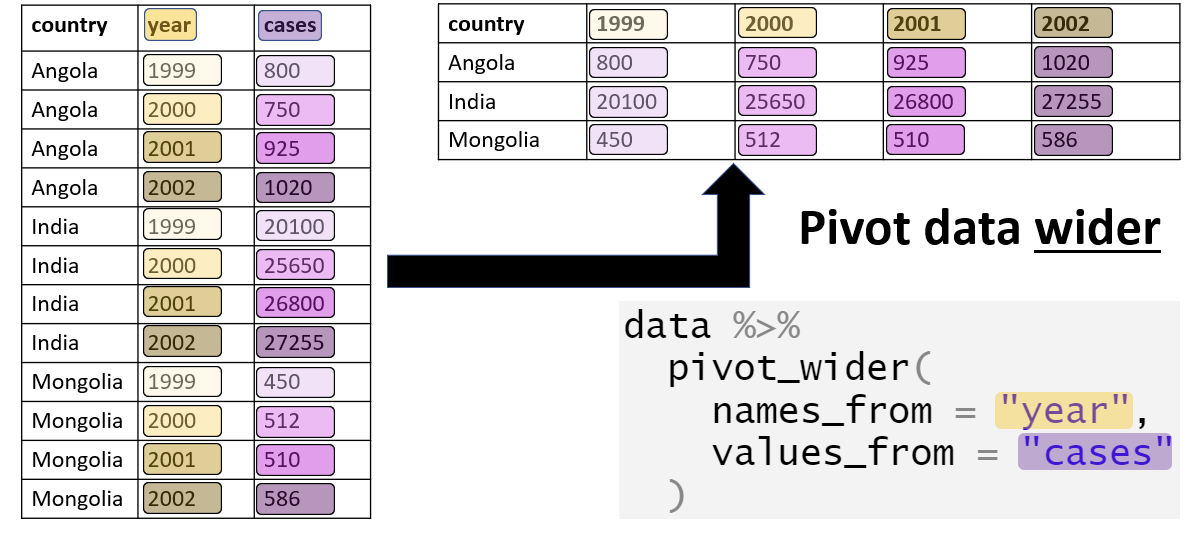

In [ ]:
stroop_effect <- filtered_id %>%
    group_by(id, trial_type) %>%
    summarize(rt = mean(rt), .groups = 'drop') %>%
    pivot_wider(names_from = trial_type, values_from = rt)

stroop_effect

Instead of specifying trial type and rt separately, we know have one column for congruent reaction times and one for incongruent ones.

##### Exercise 9
Compute the stroop effect for each participant in a new column called `stroop_rt`:

We can now sort the tibble by the `stroop_rt` column to check at a glance how robust it is:

In [ ]:
stroop_effect %>% arrange(stroop_rt)

A very consistent effect, present in all participants! This is rare.

##### Exercise 10
Extract the `stroop_rt` vector using `pull` and plot its histogram.

We can extend `pivot_wider` over multiple variables:

In [ ]:
full_stroop <- filtered_id %>%
    group_by(id, trial_type) %>%
    summarize(error = mean(1 - correct), rt = mean(rt), .groups = 'drop') %>%
    pivot_wider(names_from = trial_type, values_from = c(rt, error))
full_stroop

#### `pivot_longer`: The opposite of `pivot_wider`
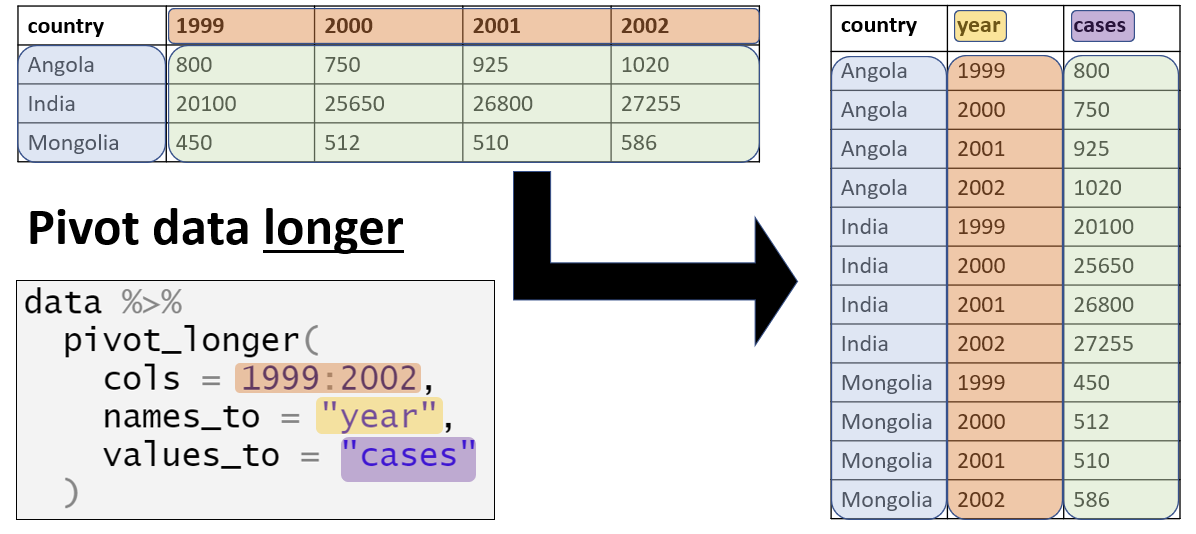

##### Exercise 11
Starting from the `full_stroop` tibble above, compute a stroop_rt and a stroop_error for each participant, then only keep id, stroop_rt, and stroop_error.
Then, using the example image above, create a new tibble with 3 columns: id, effect, and stroop_value. The `stroop_value` column should store the stroop effect, while the `effect` column should indicate whether the value in `stroop_value` is an rt or an error stroop. The outcome tibble should have 22 rows and 3 columns and start like this:

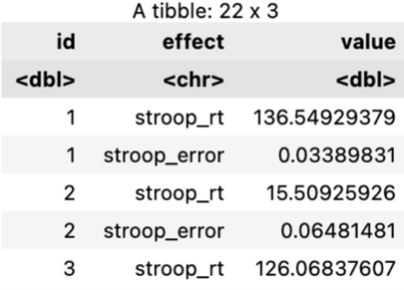

##### Exercise 12
Starting from the `full_stroop` tibble, compute the stroop effects in two separate columns, `stroop_rt` and `stroop_error`. Then extract these vectors using `pull()`, plot them using `plot(x, y)`, and compute the correlation between them.

Can you interpret this negative value?